In [6]:
import logging
import os
import sys
import tempfile
from glob import glob

import torch
from PIL import Image
from torch.utils.data import DataLoader

import monai
from monai.data import create_test_image_2d, list_data_collate, decollate_batch
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import Activations, AddChanneld, AsDiscrete, Compose, LoadImaged, SaveImage, ScaleIntensityd, EnsureTyped, EnsureType,SqueezeDimd,CropForegroundd


In [7]:
import matplotlib.pyplot as plt

def showImage(img_data,lab_data,output_data,i):
      print(img_data.size())
      img_data = img_data.cpu().squeeze()
      lab_data = lab_data.cpu().squeeze()
      output_data = output_data.cpu().squeeze()
      # img = img_data.numpy()
      # lab = lab_data.numpy()
      print(img_data.size())
      print(f"image type:{type(img_data)}\n labe_type:{type(lab_data)}")
      # plot the slice [:, :, 80]
      plt.figure("check",(20,20))
      plt.subplot(1, 3, 1)
      plt.title(f"image {i}")
      plt.imshow(img_data, cmap="gray")
      plt.subplot(1, 3, 2)
      plt.title(f"label {i}")
      plt.imshow(lab_data)
      plt.subplot(1, 3, 3)
      plt.title(f"output {i}")
      plt.imshow(output_data)
      plt.show()

/home/xindong/project/monai-test/unet-segment2d/data/imagesTest
MONAI version: 0.7.dev2133
Numpy version: 1.21.1
Pytorch version: 1.9.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 20ffa3f987fad60a8428ec635fb0b4f6ccca9747

Optional dependencies:
Pytorch Ignite version: 0.4.6
Nibabel version: 3.2.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 8.3.1
Tensorboard version: 2.6.0
gdown version: 3.13.0
TorchVision version: 0.10.0+cu111
tqdm version: 4.62.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.3.2
einops version: 0.3.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies

image size:2
label size:2
file written: /home/xindong/project/monai-test/unet-segment2d/output/0/0_seg.nii.gz.
torch.Size([1, 1, 978, 1067])
torch.Size([978, 1067])
image type:<class 't

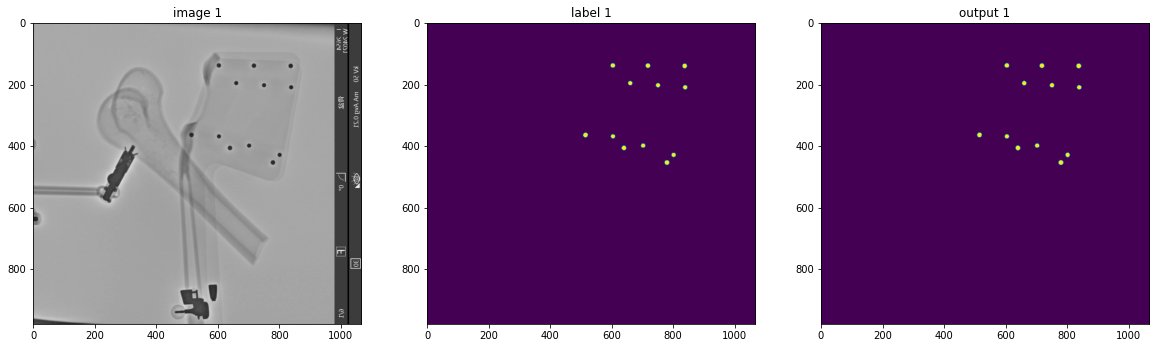

file written: /home/xindong/project/monai-test/unet-segment2d/output/1/1_seg.nii.gz.
torch.Size([1, 1, 978, 1067])
torch.Size([978, 1067])
image type:<class 'torch.Tensor'>
 labe_type:<class 'torch.Tensor'>


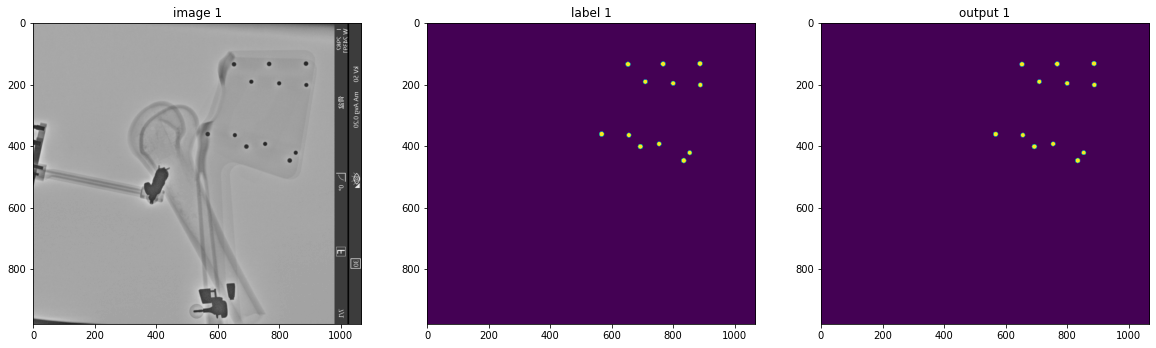

evaluation metric: 0.9793896079063416


In [8]:
def main(tempdir):
    monai.config.print_config()
    logging.basicConfig(stream=sys.stdout, level=logging.INFO)

    images = sorted(glob(os.path.join(tempdir, "img*.nii.gz")))
    segs = sorted(glob(os.path.join(tempdir, "label*.nii.gz")))
    #print(images)
    print(f"image size:{len(images)}")
    #print(segs)
    print(f"label size:{len(segs)}")

    val_files = [{"img": img, "seg": seg} for img, seg in zip(images, segs)]

    # define transforms for image and segmentation
    val_transforms = Compose(
        [
            # LoadImaged(keys=["img", "seg"]),
            # AddChanneld(keys=["img", "seg"]),
            # ScaleIntensityd(keys="img"),
            # EnsureTyped(keys=["img", "seg"]),
            
            LoadImaged(keys=["img", "seg"]),
            SqueezeDimd(keys=['img', 'seg'], dim=-1),
            AddChanneld(keys=["img", "seg"]),
            ScaleIntensityd(keys=["img", "seg"]),
            CropForegroundd(keys=["img", "seg"], source_key="img"),
            #NormalizeIntensityd(keys="img", nonzero=True, channel_wise=True),
            EnsureTyped(keys=["img", "seg"]),
        ]
    )
    val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
    # sliding window inference need to input 1 image in every iteration
    val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, collate_fn=list_data_collate)
    dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
    post_trans = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold_values=True)])
    saver = SaveImage(output_dir="./output", output_ext=".nii.gz", output_postfix="seg")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet(
        dimensions=2,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)

    model.load_state_dict(torch.load("best5_metric_model_segmentation2d_dict.pth"))

    model.eval()
    with torch.no_grad():
        for val_data in val_loader:
            val_images, val_labels = val_data["img"].to(device), val_data["seg"].to(device)
            # define sliding window size and batch size for windows inference
            roi_size = (192, 192)
            sw_batch_size = 4
            val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
            val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
            val_labels = decollate_batch(val_labels)
            # compute metric for current iteration
            dice_metric(y_pred=val_outputs, y=val_labels)
            step = 0
            for val_output in val_outputs:
                step = step + 1
                saver(val_output)
                showImage(val_images,val_data["seg"],val_output,step)
        # aggregate the final mean dice result
        print("evaluation metric:", dice_metric.aggregate().item())
        # reset the status
        dice_metric.reset()

if __name__ == "__main__":
    root_dir = os.getcwd()
    data_dir = os.path.join(root_dir, "data/imagesTest")
    print(data_dir)
    main(data_dir)
